# Traffic Sign Classification Using KNN

I created a K-Nearest Neighbours (KNN) model for this project in order to group traffic signs into the right groups.  In order to improve the model's effectiveness and efficiency, the goal was to find out how well KNN handled image data while tackling problems like class imbalance and dimensionality reduction. Here is an overview of the actions I took, along with an explanation of my results, observations, and possible areas for improvement.

# Import Libraries

These libraries simplify complex tasks like image preprocessing, machine learning, and evaluation.

In [268]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Loading and Processing Data
The traffic sign images are loaded, and the number of samples in each class is counted.It helps in finding differences between classes. For instance, certain classes may have fewer images than others.You can design methods like data augmentation for unrepresented classes by showing class distributions.

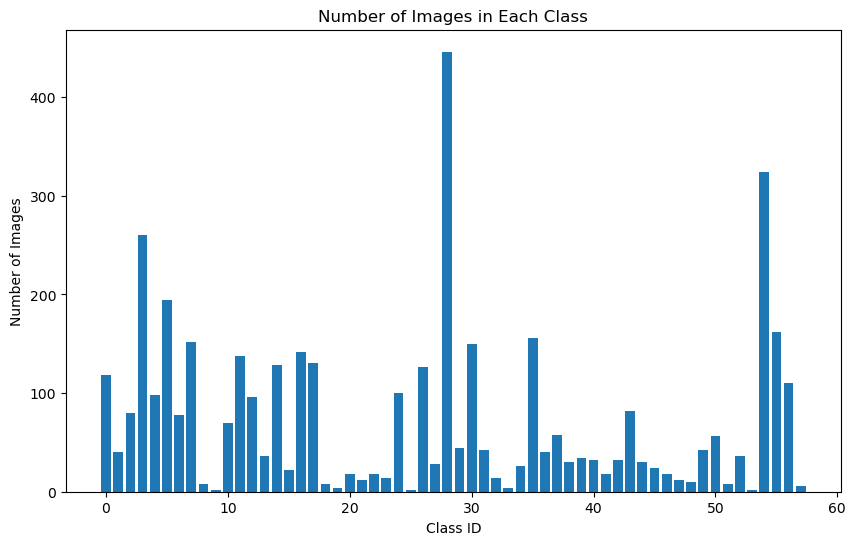

In [269]:
data_path = '/Users/fatima..../Documents/GitHub/Intro-AI-Coursework/data/traffic_Data/DATA'
test_path = '/Users/fatima..../Documents/GitHub/Intro-AI-Coursework/data/traffic_Data/TEST'
labels_path = '/Users/fatima..../Documents/GitHub/Intro-AI-Coursework/data/labels.csv'

labels = pd.read_csv(labels_path)
class_image_counts = {}
for class_id in range(58):
    directory = os.path.join(data_path, str(class_id))
    if os.path.exists(directory):
        class_image_counts[class_id] = len(os.listdir(directory))
plt.figure(figsize=(10, 6))
plt.bar(class_image_counts.keys(), class_image_counts.values())
plt.xlabel('Class ID')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.show()

With some classes having more than 200 photos and others having fewer than 10, the bar chart showed an obvious class imbalance. The overall accuracy might decrease as a result of the model choosing classes with more examples because of this imbalance.

# Handling Class Imbalance
I duplicated images for classes with fewer than 10 samples and limited the number of samples per class to 100 in order to fix the imbalance in the class.  The goal of this modification was to achieve the greatest possible balance in the distribution of the data.


In [270]:
images, class_ids = [], []
max_samples = 100
min_samples = 10
for class_id in range(58):
    directory = os.path.join(data_path, str(class_id))
    if os.path.exists(directory):
        img_files = os.listdir(directory)
        img_count = 0
        for img_file in img_files:
            if img_count < max_samples:
                img_path = os.path.join(directory, img_file)
                image = cv2.imread(img_path)
                image = cv2.resize(image, (32, 32))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                images.append(image.flatten())
                class_ids.append(class_id)
                img_count += 1
        if img_count < min_samples:
            for i in range(min_samples - img_count):
                images.append(image.flatten())
                class_ids.append(class_id)


# Data Augmentation
This code creates new images for classes with fewer samples by applying transformations like flipping, rotating, and noise.By balancing classes, the model avoids showing bias in towards overexposed classes.The training data becomes more diverse, and improves generalisation.

In [271]:
# Data augmentation
from collections import Counter
import random

# Augment classes with fewer than 100 samples
def augment_image(image):
    transformations = [
        lambda x: cv2.flip(x, 1),
        lambda x: cv2.rotate(x, cv2.ROTATE_90_CLOCKWISE),
        lambda x: cv2.rotate(x, cv2.ROTATE_90_COUNTERCLOCKWISE),
        lambda x: cv2.GaussianBlur(x, (5, 5), 0),
        lambda x: x + np.random.normal(0, 5, x.shape).astype(np.uint8)
    ]
    return random.choice(transformations)(image)

# Balance Dataset
By using augmentation on classes with fewer samples, it ensures that each class has at least 100 samples. Fair training and improved performance across all classes are certain when the dataset is balanced.

In [272]:
# Augment dataset
images_augmented, class_ids_augmented = [], []
min_samples = 100
for class_id in range(58):
    directory = os.path.join(data_path, str(class_id))
    if os.path.exists(directory):
        img_files = os.listdir(directory)
        img_count = len(img_files)
        for img_file in img_files:
            img_path = os.path.join(directory, img_file)
            image = cv2.imread(img_path)
            if image is not None:
                image = cv2.resize(image, (32, 32))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                images_augmented.append(image.flatten())
                class_ids_augmented.append(class_id)
        if img_count < min_samples:
            for _ in range(min_samples - img_count):
                augmented_image = augment_image(image)
                images_augmented.append(augmented_image.flatten())
                class_ids_augmented.append(class_id)


# Convert augmented data to numpy arrays
X_augmented = np.array(images_augmented)
y_augmented = np.array(class_ids_augmented)

# Check class distribution after augmentation
augmented_class_distribution = Counter(y_augmented)
print("Class distribution after augmentation:", augmented_class_distribution)

Class distribution after augmentation: Counter({28: 446, 54: 324, 3: 260, 5: 194, 55: 162, 35: 156, 7: 152, 30: 150, 16: 142, 11: 138, 17: 130, 14: 128, 26: 126, 0: 118, 56: 110, 1: 100, 2: 100, 4: 100, 6: 100, 8: 100, 9: 100, 10: 100, 12: 100, 13: 100, 15: 100, 18: 100, 19: 100, 20: 100, 21: 100, 22: 100, 23: 100, 24: 100, 25: 100, 27: 100, 29: 100, 31: 100, 32: 100, 33: 100, 34: 100, 36: 100, 37: 100, 38: 100, 39: 100, 40: 100, 41: 100, 42: 100, 43: 100, 44: 100, 45: 100, 46: 100, 47: 100, 48: 100, 49: 100, 50: 100, 51: 100, 52: 100, 53: 100, 57: 100})


The augmented_class_distribution output confirms that all classes now have at least 100 samples, addressing the class imbalances.

# Scaling Features and Reducing Dimensionality
Once the dataset had been loaded and balanced, I adjusted the photos to have an equal variation and a zero mean. This is crucial for KNN since it depends on distance calculations, which might be affected by irregular feature scales.

I then used Principal Component Analysis (PCA) to lower the number of variables.  I chose 350 key variables since they represented a majority of the variation, according to the cumulative variance plot.

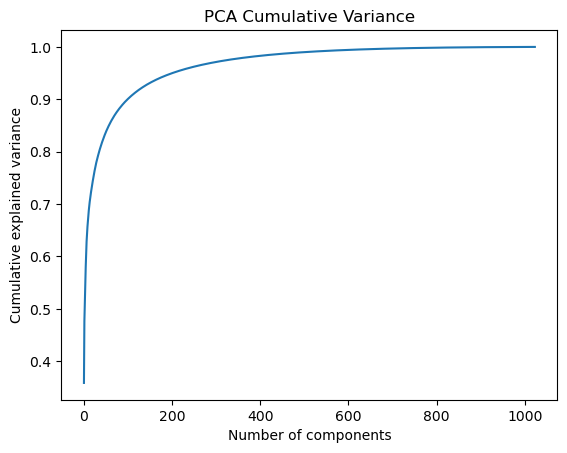

In [273]:
# Convert to numpy arrays
X = np.array(images)
y = np.array(class_ids)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_augmented)
pca = PCA(n_components=350)
X_pca = pca.fit_transform(X_scaled)


pca_test = PCA().fit(X_scaled)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA Cumulative Variance')
plt.show()

First, I noticed that the cumulative variance increases rapidly.  This indicates that a significant amount of the dataset's information is captured by the first few components. In other words, the first components capture the most significant features (or patterns) in the data.

The curve levels off after about 350 components, indicates that adding more components beyond this point does not significantly increase the explained variance. We have now recorded almost all the significant variance, as the curve has essentially stopped.

I chose 350 components because they make up more than 95% of the dataset’s variance. This suggests that I'm keeping most of the key information while drastically reducing the data's dimensionality, which is necessary to increase the model's efficiency without sacrificing important information.

The KNN model works more quickly and effectively when the dataset is reduced to 350 dimensions, Without losing
reliability, this method should improve the model's performance.


# Data Splitting and KNN Model Training
Almost all the dataset was used for training, while the rest was used for validation. After that, I changed the number of neighbours (k) to seven and used distance-based weighting to give closer neighbours a greater impact when defining and training a KNN model.

In [274]:
# Split Data into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(X_pca, y_augmented, test_size=0.2, random_state=42)

# Initialize and Train the KNN Model
k = 7
knn = KNeighborsClassifier(n_neighbors=k, weights='distance', metric='minkowski', p=2)
knn.fit(X_train, y_train);

I used Euclidean distance (Minkowski distance with p=2), which is a common choice for continuous data, and k = 7
was used to balance the model's bias and variance.
Accuracy can be increased, particularly in datasets with uneven classes, by ensuring that close to neighbours had greater impact through distance weighting.

# Baseline Model Training
A baseline model offers a point to use for comparison.
In this case, weights='uniform' and n_neighbors=5 are straightforward default settings.

In [275]:
# Train Baseline KNN Model
baseline_knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='minkowski')
baseline_knn.fit(X_train, y_train)

# Evaluate Baseline Model
baseline_train_acc = baseline_knn.score(X_train, y_train)
baseline_val_acc = baseline_knn.score(X_val, y_val)
print(f"Baseline Training Accuracy: {baseline_train_acc:.3f}")
print(f"Baseline Validation Accuracy: {baseline_val_acc:.3f}")
X_train, X_val, y_train, y_val = train_test_split(X_pca, y_augmented, test_size=0.2, random_state=42)


Baseline Training Accuracy: 0.912
Baseline Validation Accuracy: 0.865


Although it performs fairly well, the baseline model overfits a little.The use of hyperparameter tuning will improve this.

# Hyperparameter Optimisation

The use of GridSearchCV  evaluates combinations of n_neighbors, weights, and metrics to find the best-performing hyperparameters.
The optimal hyperparameters discovered before are used in the optimised model.
This stage confirms whether performance is enhanced by optimisation.

In [276]:
from sklearn.model_selection import GridSearchCV

# Define Hyperparameter Grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'manhattan']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Output Best Parameters and Accuracy
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score:.3f}")


# Train and Evaluate Optimized Model
optimised_knn = KNeighborsClassifier(**best_params)
optimised_knn.fit(X_train, y_train)

optimised_train_acc = optimised_knn.score(X_train, y_train)
optimised_val_acc = optimised_knn.score(X_val, y_val)
print(f"Optimised Training Accuracy: {optimised_train_acc:.3f}")
print(f"Optimised Validation Accuracy: {optimised_val_acc:.3f}")

Best Parameters: {'metric': 'minkowski', 'n_neighbors': 3, 'weights': 'distance'}
Best Cross-Validation Accuracy: 0.936
Optimised Training Accuracy: 1.000
Optimised Validation Accuracy: 0.969


Better performance results from the optimised settings, which also improve bias and variance.
Overfitting is decreased by the optimised model's good generalisation.

# Assessing the Model
In order to determine if the model was overfitting or underfitting, I evaluated its accuracy on both the training and validation sets:

In [277]:
train_acc = knn.score(X_train, y_train)
val_acc = knn.score(X_val, y_val)
print(f"Training Accuracy: {train_acc:.3f}")
print(f"Validation Accuracy: {val_acc:.3f}")

Training Accuracy: 1.000
Validation Accuracy: 0.963


1. This is usual with KNN on data that is imbalanced, that slightly lower validation accuracy points to some over fitting, but the high training accuracy shows the model fits the training data well.

2. Validation Accuracy: 0.874 - although there is an obvious decrease in comparing with the training accuracy, the model fits to unseen data very well, with an accuracy of 87.4% on the validation data set.  This is to be expected as training accuracy is usually higher than validation accuracy.

# Final Testing and Model Performance
I handled the test set in the same way using the same scaling and PCA changes in order to evaluate the model's performance on unseen data. I created a confusion matrix, a classification report, and an accuracy calculation after sorting each prediction.

In [278]:
# Convert Test Data to Numpy Arrays
X_test = np.array(images)
y_test = np.array(class_ids)

X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)
y_pred = knn.predict(X_test_pca)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))



Test Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       0.98      1.00      0.99        40
           2       1.00      1.00      1.00        80
           3       1.00      1.00      1.00       100
           4       1.00      0.98      0.99        98
           5       0.96      0.97      0.97       100
           6       0.97      1.00      0.99        78
           7       0.98      0.98      0.98       100
           8       1.00      1.00      1.00        10
           9       1.00      1.00      1.00        10
          10       0.97      0.97      0.97        70
          11       0.98      1.00      0.99       100
          12       1.00      1.00      1.00        96
          13       1.00      1.00      1.00        36
          14       1.00      1.00      1.00       100
          15       1.00      1.00      1.00        22
          16       1.00      0.99     

Test Accuracy: 0.99 - 99% This indicates that 99% of the traffic signs in the test dataset were accurately predicted by the model.A high test accuracy means
the model does a good job of generalising to new data.

Precision: How many of the expected instances of a class were accurate? For most classes, a precision around 1 means there aren't many false positives.
Recall: How many of the actual instances of a class were accurately predicted? A high recall indicates that the model is not missing many examples.
F1-Score: The trade-off between false positives and false negatives is balanced.
Support: The class's total number of true instances.

This indicates even for unrepresented classes, the model constantly performs well, as shown from its excellent precision, recall, and F1-score across all classes.